# What is this about?



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
clear_output()

In [1]:
%%capture

# Importing and inatalling packages we will use for this notebook
# !sudo apt-get update #&& sudo apt-get upgrade -y
!sudo apt-get install tree
!pip install -U ipywidgets
!pip install ultralytics
# !pip install scipy --upgrade
!pip install -q roboflow  supervision
!pip install --upgrade pip setuptools jupyter-lsp packaging shapely
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install numpy==1.22.4
import sys, os, distutils.core
from IPython.display import clear_output
import yaml
import shutil
import numpy as np
import random
import cv2
import torch
import supervision as sv
import matplotlib.pyplot as plt
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
clear_output()
# ultralytics.checks()

In [3]:
!tree -d /kaggle/input/bloodcell-yolo-format

/kaggle/input/bloodcell-yolo-format
|-- test
|   |-- images
|   `-- labels
|-- train
|   |-- images
|   `-- labels
`-- valid
    |-- images
    `-- labels

9 directories


In [2]:
# Define the source and destination paths
source_dir = '/kaggle/input/bloodcell-yolo-format'
destination_dir = '/kaggle/working/bloodcell-yolo-format'

for subdir, dirs, files in os.walk(source_dir):
    # Determine the destination directory path
    dest_subdir = subdir.replace(source_dir, destination_dir, 1)

    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_subdir):
        os.makedirs(dest_subdir)

    # Copy each file in the current directory
    for file in files:
        src_file = os.path.join(subdir, file)
        dest_file = os.path.join(dest_subdir, file)
        shutil.copy2(src_file, dest_file)

print("Copying completed successfully.")

Copying completed successfully.


In [3]:
with open('/kaggle/working/bloodcell-yolo-format/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 7,
 'names': ['basophil',
  'eosinophil',
  'lymphocyte',
  'monocyte',
  'neutrophil',
  'platelets',
  'rbc'],
 'roboflow': {'workspace': 'bloodcell-0xux9',
  'project': 'bloodcell-bu6q7',
  'version': 2,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/bloodcell-0xux9/bloodcell-bu6q7/dataset/2'}}

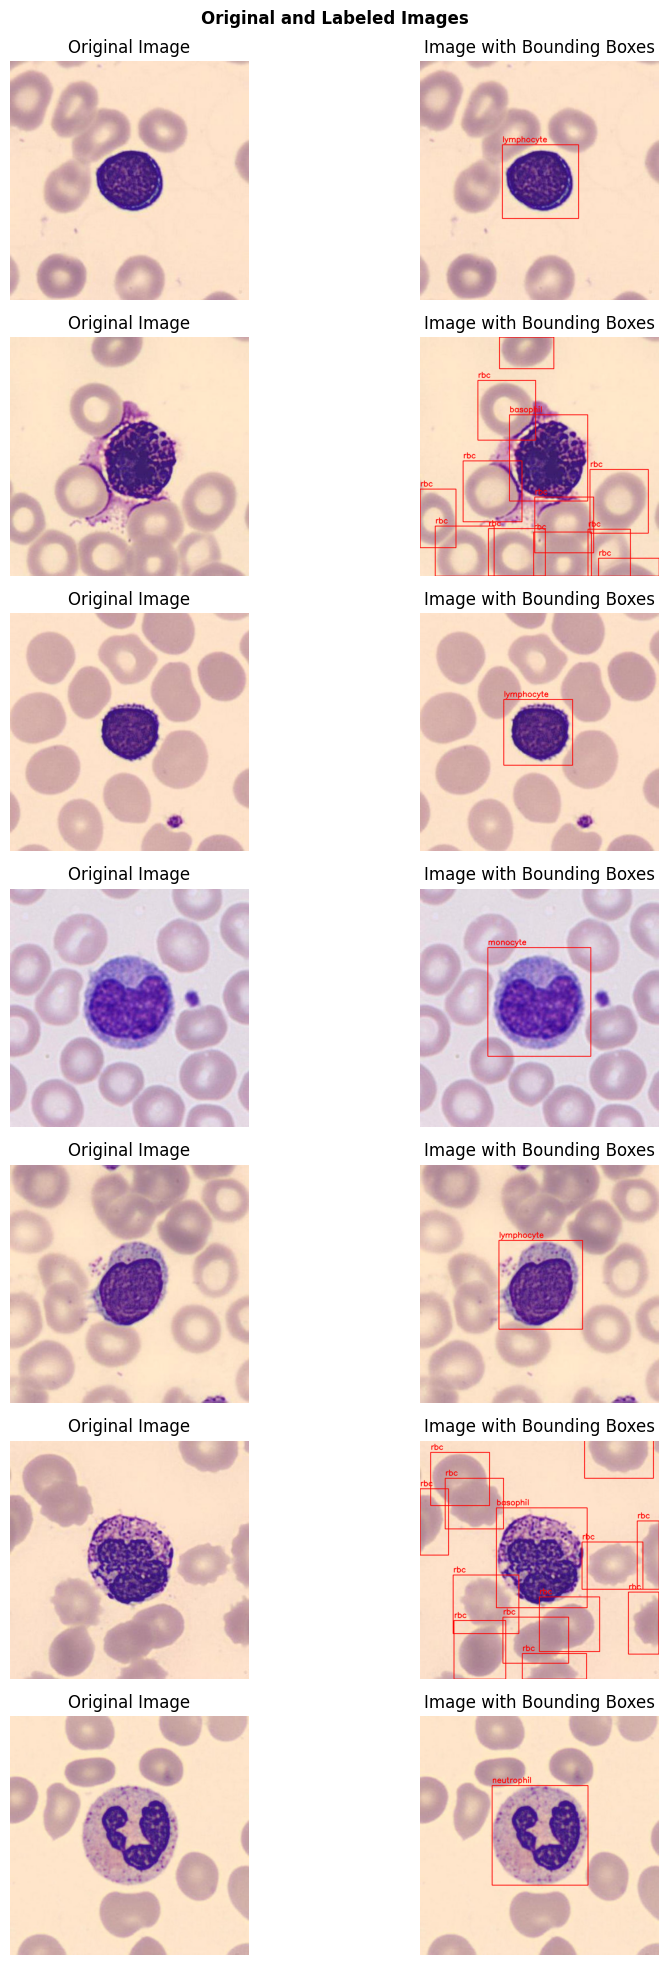

In [4]:
# Function to read and convert bounding box coordinates from a file
def read_bboxes(file_path, img_shape, class_names):
    with open(file_path, 'r') as file:
        bboxes = []
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_center, y_center, width, height = x_center * img_shape[1], y_center * img_shape[0], width * img_shape[1], height * img_shape[0]
            x, y = int(x_center - width / 2), int(y_center - height / 2)
            bboxes.append([class_names[int(class_id)], int(x), int(y), int(width), int(height)])
    return bboxes

# Function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    for bbox in bboxes:
        class_name, x, y, w, h = bbox
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, class_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return image

# Read data.yaml to get class names
with open('/kaggle/working/bloodcell-yolo-format/data.yaml', 'r') as file:
    yaml_data = yaml.safe_load(file)
    class_names = yaml_data['names']

# Directories for images and labels
image_dir = '/kaggle/working/bloodcell-yolo-format/train/images'
bbox_dir = '/kaggle/working/bloodcell-yolo-format/train/labels'

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:7]

# Create subplots
fig, axes = plt.subplots(len(selected_images), 2, figsize=(10, 20))
fig.suptitle('Original and Labeled Images\n', fontweight='bold')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape, class_names)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)

    # Show original and labeled images
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Image with Bounding Boxes')

plt.tight_layout()
plt.show()

## Training

In [6]:
%%capture

model = YOLO('yolov8m.pt')
os.environ["WANDB_MODE"] = "dryrun"

result = model.train(data='/kaggle/working/bloodcell-yolo-format/data.yaml',
                     
                     # Project
                     project="bloodlab",
                     name="bctest",
                     seed=43,
                     exist_ok=True,
                     cache=True,
                     
                     # Params
                     epochs=20,
                     batch=32,
                     imgsz=704,
                     patience=7,
                     plots=False,
#                      save=False,
                     verbose=False,
                     device=[0,1]
                    )

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
                                                     CUDA:1 (Tesla T4, 15102MiB)
TensorBoard: Start with 'tensorboard --logdir bloodlab/bctest', view at http://localhost:6006/


wandb: Tracking run with wandb version 0.16.2
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Overriding model.yaml nc=80 with nc=7
Transferred 469/475 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/bloodcell-yolo-format/train/labels.cache... 6000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6000/6000 [00:00<?, ?it/s]
train: Caching images (8.3GB True): 100%|██████████| 6000/6000 [00:27<00:00, 215.61it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/bloodcell-yolo-format/valid/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
val: Caching images (1.4GB True): 100%|██████████| 1000/1000 [00:09<00:00, 106.96it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 704 train, 704 val
Using 4 dataloader workers
Logging results to bloodlab/bctest
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.16G     0.7985      1.584      1.109         68        704: 100%|██████████| 188/188 [02:25<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


                   all       1000       1055      0.901      0.834      0.905       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      9.49G     0.7317     0.9981      1.072         88        704: 100%|██████████| 188/188 [02:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.973      0.849       0.95      0.809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      9.35G     0.7187     0.9576      1.068         79        704: 100%|██████████| 188/188 [02:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.925      0.811        0.9      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      9.35G     0.7014     0.8929      1.055         72        704: 100%|██████████| 188/188 [02:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


                   all       1000       1055      0.906      0.901      0.948      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      9.38G     0.6798     0.8343      1.037         72        704: 100%|██████████| 188/188 [02:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.932      0.928      0.973      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       9.3G     0.6666     0.7912      1.028         78        704: 100%|██████████| 188/188 [02:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.911       0.91      0.956       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      9.37G     0.6485     0.7743      1.019         61        704: 100%|██████████| 188/188 [02:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.936      0.939      0.969      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      9.35G     0.6401     0.7554      1.023         58        704: 100%|██████████| 188/188 [02:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.959      0.943      0.981      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      9.37G     0.6302     0.7263      1.011         23        704: 100%|██████████| 188/188 [02:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.952      0.963      0.982      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      9.42G     0.6247     0.7366      1.016         50        704: 100%|██████████| 188/188 [02:00<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.938      0.914       0.97      0.868
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      9.32G     0.5988     0.6201      1.018         57        704: 100%|██████████| 188/188 [02:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.976      0.976      0.991      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      9.35G      0.594     0.6149      1.019         52        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.952      0.972      0.987      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      9.32G     0.5839     0.5775      1.013         46        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


                   all       1000       1055      0.979       0.97       0.99      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      9.35G     0.5706     0.5513      1.001         26        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.974      0.983       0.99      0.894

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      9.32G     0.5635       0.55     0.9955          8        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.988      0.979      0.992      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      9.34G     0.5615     0.5347     0.9962         53        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


                   all       1000       1055       0.98      0.985      0.992      0.903

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      9.38G     0.5579     0.5392     0.9891         50        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.972      0.977      0.989      0.892

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      9.38G     0.5484     0.5266     0.9904          8        704: 100%|██████████| 188/188 [01:59<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055      0.981      0.993      0.992      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      9.36G      0.537     0.5147     0.9817         27        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.03it/s]


                   all       1000       1055       0.99      0.985      0.992      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.37G     0.5415     0.5184     0.9754         34        704: 100%|██████████| 188/188 [01:59<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s]


                   all       1000       1055      0.981      0.988      0.992       0.91

20 epochs completed in 0.780 hours.
Optimizer stripped from bloodlab/bctest/weights/last.pt, 52.0MB
Optimizer stripped from bloodlab/bctest/weights/best.pt, 52.0MB

Validating bloodlab/bctest/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
                                                     CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25843813 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


                   all       1000       1055      0.981      0.988      0.992       0.91
Speed: 0.2ms preprocess, 12.9ms inference, 0.0ms loss, 0.8ms postprocess per image


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Traceback (most recent call last):
  File "/root/.config/Ultralytics/DDP/_temp___wd81gr139976347643248.py", line 12, in <module>
    results = trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 208, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 468, in _do_train
    self.run_callbacks("on_train_end")
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 171, in run_callbacks
    callback(self)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/utils/callbacks/wb.py", line 141, in on_train_end
    _plo

CalledProcessError: Command '['/opt/conda/bin/python3.10', '-m', 'torch.distributed.run', '--nproc_per_node', '2', '--master_port', '50155', '/root/.config/Ultralytics/DDP/_temp___wd81gr139976347643248.py']' returned non-zero exit status 1.

In [ ]:
# take a look at learning process
result_curves = cv2.cvtColor(cv2.imread('/kaggle/working/runs/detect/train/results.png'),cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.title('Results')
plt.axis('off')
plt.imshow(result_curves)

In [ ]:
# Prediction on test set
model.predict('/kaggle/input/bloodcell-yolo-format/test/images',save=True,show_labels=True)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mv /kaggle/working/runs/detect/train2 /kaggle/working/runs/detect/preds

In [ ]:
!tree -d /kaggle/working/runs/

In [ ]:
image_dir = '/kaggle/input/bloodcell-yolo-format/test/images'
bbox_dir = '/kaggle/input/bloodcell-yolo-format/test/labels'

# Get a list of image file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
random.shuffle(image_files)

# Select 5 random images
selected_images = image_files[:5]

# Create subplots
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
fig.suptitle('Predictions vs Ground Truth Labels')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    bbox_path = os.path.join(bbox_dir, os.path.splitext(img_file)[0] + '.txt')

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_shape = image.shape

    # Read and draw bounding boxes
    bboxes = read_bboxes(bbox_path, img_shape, class_names)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)

    # Read the predicted image (assuming it's stored at the specified path)
    prediction_path = '/kaggle/working/runs/detect/preds/' + img_file
    if os.path.exists(prediction_path):
        prediction = cv2.imread(prediction_path)
        prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    else:
        prediction = None

    # Show prediction and ground truth labeled images
    if prediction is not None:
        axes[i, 0].imshow(prediction)
        axes[i, 0].set_title('Prediction')
    else:
        axes[i, 0].text(0.5, 0.5, 'No Prediction Image', horizontalalignment='center', verticalalignment='center', transform=axes[i, 0].transAxes)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(image_with_bboxes)
    axes[i, 1].set_title('Ground Truth Label')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Segmentation with SAM

In [ ]:
# NOTE: To make it easier for us to manage datasets, images and models we create a HOME constant.
HOME = os.getcwd()
print("HOME:", HOME)

In [ ]:
# Download SAM weights
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [ ]:
# A quick sanity check to see if the weights are downloaded
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

In [ ]:
# Loading the model
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [ ]:
# Function to load an image, perform YOLO prediction, and SAM segmentation
def load_and_predict(image_path, model, mask_predictor):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform YOLO prediction
    result = model([image_rgb], iou=0.70, conf=0.40)
    boxes = result[0].boxes.xyxy.tolist()
    
    segmented_image = None
    for box in boxes:
        mask_predictor.set_image(image_rgb)
        masks, _, _ = mask_predictor.predict(box=np.array(box), multimask_output=True)
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks), mask=masks)
        detections = detections[detections.area == np.max(detections.area)]
        segmented_image = mask_annotator.annotate(scene=image_rgb, detections=detections)

    return image, segmented_image

# Set the paths
image_dir = '/kaggle/input/bloodcell-yolo-format/test/images'
pred_dir = '/kaggle/working/runs/detect/preds'

# Process images
images_num = 5
selected_images = random.sample([f for f in os.listdir(image_dir) if f.endswith('.jpg')], images_num)

# Visualization
fig, axes = plt.subplots(images_num, 2, figsize=(10, 20))
fig.suptitle('YOLO Predictions vs SAM Segmentations\n', fontweight='bold')

for i, img_file in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_file)
    pred_path = os.path.join(pred_dir, img_file)

    original_image, segmented_image = load_and_predict(img_path, model, mask_predictor)

    # Display YOLO prediction
    if os.path.exists(pred_path):
        prediction = cv2.cvtColor(cv2.imread(pred_path), cv2.COLOR_BGR2RGB)
        axes[i, 0].imshow(prediction)
    else:
        axes[i, 0].text(0.5, 0.5, 'No Prediction Image', horizontalalignment='center', verticalalignment='center', transform=axes[i, 0].transAxes)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('YOLO Prediction')

    # Display SAM segmentation
    if segmented_image is not None:
        axes[i, 1].imshow(segmented_image)
    else:
        axes[i, 1].text(0.5, 0.5, 'No Segmentation', horizontalalignment='center', verticalalignment='center', transform=axes[i, 1].transAxes)
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Segmentation With SAM')

plt.tight_layout()
plt.show()